<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/codice_bpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # allows vectorized operations
import cupy as cp # fork of numpy
from scipy.optimize import curve_fit
# allows vectorized operations on GPU
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# plot style parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7f9fc'

Prima di tutto definiamo delle funzioni di plot.

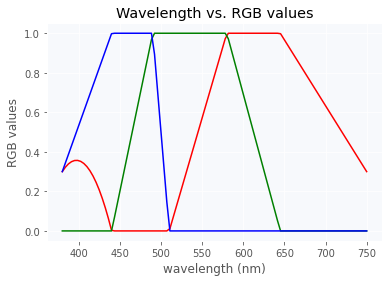

In [2]:
from matplotlib.colors import LinearSegmentedColormap
'''
To make more realistic plots we define a function
returning approzimated colormap from wavelength.
There is not a simple form for it, because of the
complex mechanisms of human vision and trichromy.
The physical model of colors mixing is achieved 
by summing values in RGB and clipping the results at 1.
'''
def wavelength_to_rgb(wavelength): # input in meters
    wavelength = wavelength*1e9 # nm
    '''
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wl = float(wavelength)
    if wl < 380: wl = 380
    if wl > 750: wl = 750
    if wl >= 380 and wl <= 440:
        att = 0.3 + 0.7 * (wl - 380) / (440 - 380) # attenuation
        R, G, B = ((-(wl - 440) / (440 - 380)) * att), 0, (1.0 * att)
    elif wl >= 440 and wl <= 490:
        R, G, B = 0.0, ((wl - 440) / (490 - 440)), 1
    elif wl >= 490 and wl <= 510:
        R, G, B = 0.0, 1, (-(wl - 510) / (510 - 490))
    elif wl >= 510 and wl <= 580:
        R, G, B = ((wl - 510) / (580 - 510)), 1, 0
    elif wl >= 580 and wl <= 645:
        R, G, B = 1.0, (-(wl - 645) / (645 - 580)), 0
    elif wl >= 645 and wl <= 750:
        att = 0.3 + 0.7 * (750 - wl) / (750 - 645)
        R, G, B = (1.0 * att), 0, 0
    else:
        R, G, B = 0, 0, 0
    return cp.asarray([R, G, B])

wavelengths = np.linspace(380, 750, 100)*1e-9 # in meters
rgbs = np.stack([cp.asnumpy(wavelength_to_rgb(wl)) for wl in wavelengths])
plt.plot(1e9*wavelengths, rgbs[:, 0], "r-")
plt.plot(1e9*wavelengths, rgbs[:, 1], "g-")
plt.plot(1e9*wavelengths, rgbs[:, 2], "b-")
plt.xlabel("wavelength (nm)")
plt.ylabel("RGB values")
plt.title("Wavelength vs. RGB values")
plt.savefig("wl-rgb.pdf")
plt.show()


In [0]:
def wavelength_to_cmap(wavelength):
  R, G, B = wavelength_to_rgb(wavelength)
  cdict = {
        'red':  [[0.0,  0.0, 0.0],
                  [1.0,  R, R]],
        'green': [[0.0,  0.0, 0.0],
                  [1.0,  G, G]],
        'blue':  [[0.0,  0.0, 0.0],
                  [1.0,  B, B]]
            }
  return LinearSegmentedColormap('Cmap', segmentdata=cdict, N=256)
# default colormap is black screen with red light - similar to lab situation
default_wavelength = 651*1e-9 # meters
default_cmap = wavelength_to_cmap(default_wavelength)

In [0]:
# we define a function to plot 
def plot(Power, 
         figsize=(15, 15), width=15, unit="mm", cmap=default_cmap, 
         fig=None, ax=None, OneD=False,
):
  if OneD:
    Power = cp.stack((Power,)*100, axis=0)  
  if type(Power)==cp.core.core.ndarray:
    Power = cp.asnumpy(Power)
  if fig is None:
    fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  im = ax.imshow(Power, 
      cmap=cmap, extent=[-width,width,-width,width], vmin=0, animated=True)
  return fig, ax, im

In [0]:
def save_animation(memory, filename, axis=1, every=1, OneD=False, blit=True, width=15):
  ims = []
  fig, ax = plt.subplots(figsize=(10, 10))
  N = memory.shape[axis]
  for n in range(N):
    if n%every == 0:
      fig, ax, im = plot(cp.take(memory, n, axis=axis), fig=fig, ax=ax, OneD=OneD, width=width)
      ims.append([im])
      print(f"\r{n/N}:.1f", end="", flush=True)

  ani = animation.ArtistAnimation(fig, ims, interval=100, blit=blit)

  Writer = animation.writers['ffmpeg']
  writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
  ani.save(filename, writer=writer)
  del ims
  plt.close()

Definiamo a questo punto le funzioni per propagare.

In [0]:
fft1, ifft1 = cp.fft.fft, cp.fft.ifft # cpu fft when in 1D
fft2, ifft2 = cp.fft.fft2, cp.fft.ifft2 # gpu fft when in 2D

In [0]:
def propagate(Field, k, 
  grid_setup=None, keep_memory=False, threshold=1e-14, check_energy=False):
  # k_square_grid is KX**2 + KY**2 in 2D and kx**2 in 1D
  nstepx, nstepz, deltaz, k_square_grid = grid_setup
  # establish which numerical lib to use
  if Field.ndim == 1:
    fft, ifft = fft1, ifft1
    fmm_shape = (nstepx, nstepz+1)
  elif Field.ndim == 2:
    fft, ifft = fft2, ifft2
    fmm_shape = (nstepx, nstepx, nstepz+1)
  if keep_memory:
    # keeps a record of field module at every step
    FieldModuleMemory = cp.zeros(shape=fmm_shape)
    FieldModuleMemory[..., 0] = cp.abs(Field)

  ArgumentOfPropagator  = ((k*n0)**(-1)*k_square_grid)*(deltaz/2);             
  Propagator = cp.exp(1j*ArgumentOfPropagator)
  if check_energy:
    InputPower = cp.abs(Field)**2

  tstart = time.time()
  for step in range(nstepz):
      Field = ifft(fft(Field)*Propagator)
      if keep_memory:
        FieldModuleMemory[..., 1+step] = cp.abs(Field)
  print(f"Lasted {time.time()-tstart} seconds")

  if check_energy:
    OutputPower = cp.abs(Field)**2
    OutputTotalPower = cp.sum(OutputPower) # total power on output plane
    InputTotalPower = cp.sum(InputPower) # total power on input plane
    gap = (OutputTotalPower-InputTotalPower)/(OutputTotalPower+InputTotalPower)
    if gap > threshold:
      raise ValueError("Energy not conserved")

  if keep_memory:
      return Field, FieldModuleMemory
  else:
      return Field

In [0]:
def propagate_and_get_rgb(InputField, wavelength, grid=None, keep_memory=False):
  k = 2*np.pi/(wavelength)
  rgb = wavelength_to_rgb(wavelength)
  if keep_memory:
    OutputField, IntMem = propagate(InputField, k, grid, keep_memory=True)
    IntMem = IntMem**2
    IntMem /= cp.amax(IntMem, axis=tuple(range(IntMem.ndim-1)))
    IntMemRGB = cp.stack((IntMem,)*3, axis=-1)*rgb
  else:
    OutputField = propagate(InputField, k, grid)
  P = cp.abs(OutputField)**2
  
  outRGB = cp.stack((P,)*3, axis=-1)/cp.max(P)*rgb
  if keep_memory:
    return (outRGB, IntMemRGB)
  else:
    return outRGB

# Fascio Gaussiano 2D

In [0]:
################### Physical Parameters  ########################
Ip = 4**2; # peak intensity               
Ib = 1.0; # background illumination                       
Lambda = 0.651e-6; # wavelength of red light
k0 = 2*np.pi/Lambda; # vacuum wavevector                 
n0 = 1; # background index of refraction      
Lz = 5; # computational length of sample    
Lx = 3e-2; # computational width of sample          
h = 0*0.67e-3;
xshift = +h/2; # input position on x axis               
w0 = 0.02*Lx # beam width of gaussian beam parameter


################## Computational Parameters #############
nstepx = 1024; # number of transverse grid points
nstepz = 20; # number of longitudinal propagation steps

deltax = Lx/nstepx;
deltaz = Lz/nstepz; # resolution in the z direction, IMPORTANT
deltaf = 1/Lx; # spatial frequency step

In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = cp.arange(0, Lz+deltaz, deltaz) # z array            
x = -Lx/2 +(cp.arange(0, nstepx, 1))*deltax; # x array               

X, Y = cp.meshgrid(x,x); # x and y grid

##########################  Dispersive Step Setup #########################
# this is to get rid of fftshifts and the sort

ntx = 0;             
kx = cp.zeros(nstepx)                                          
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*np.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

KX, KY = cp.meshgrid(kx, kx);

grid_setup = (nstepx, nstepz, deltaz, KX**2+KY**2)

In [0]:
####################### INPUT FIELDS DEFINITION  #########################
# gaussian beam
InputField = cp.sqrt(Ip)*cp.exp(-(X**2+Y**2)/(w0**2));

InputPower = cp.abs(InputField)**2

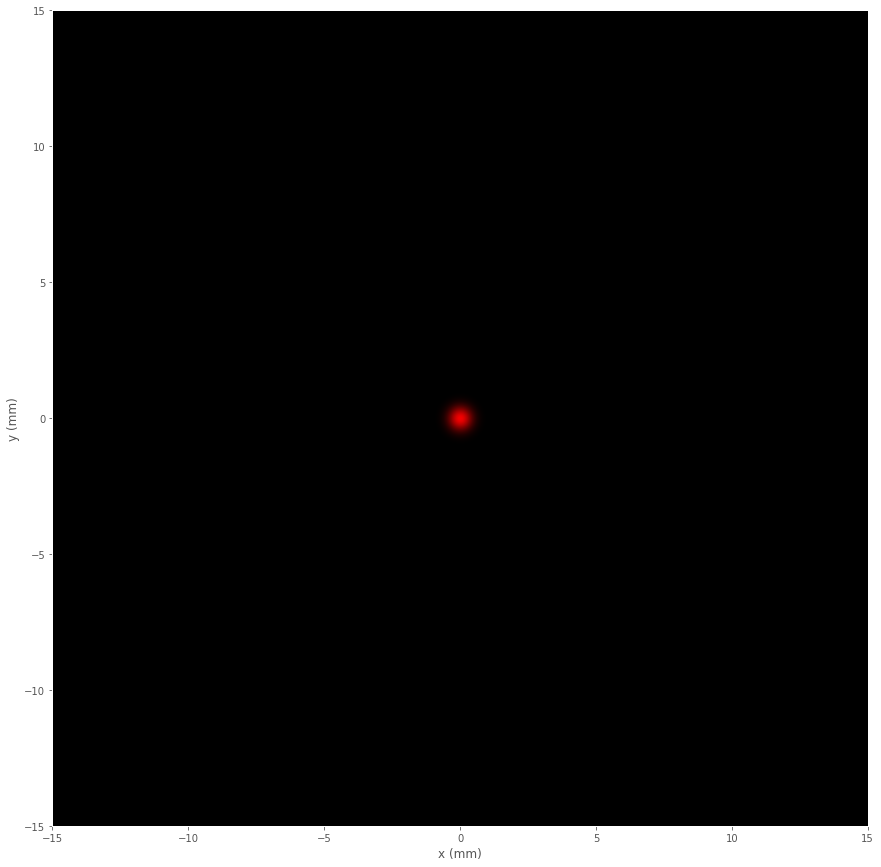

In [190]:
fig, ax, im = plot(InputPower, width=Lx*0.5e3)
fig.savefig("gaussianinputfield.pdf")
plt.show()
plt.close()

Lasted 0.04072093963623047 seconds


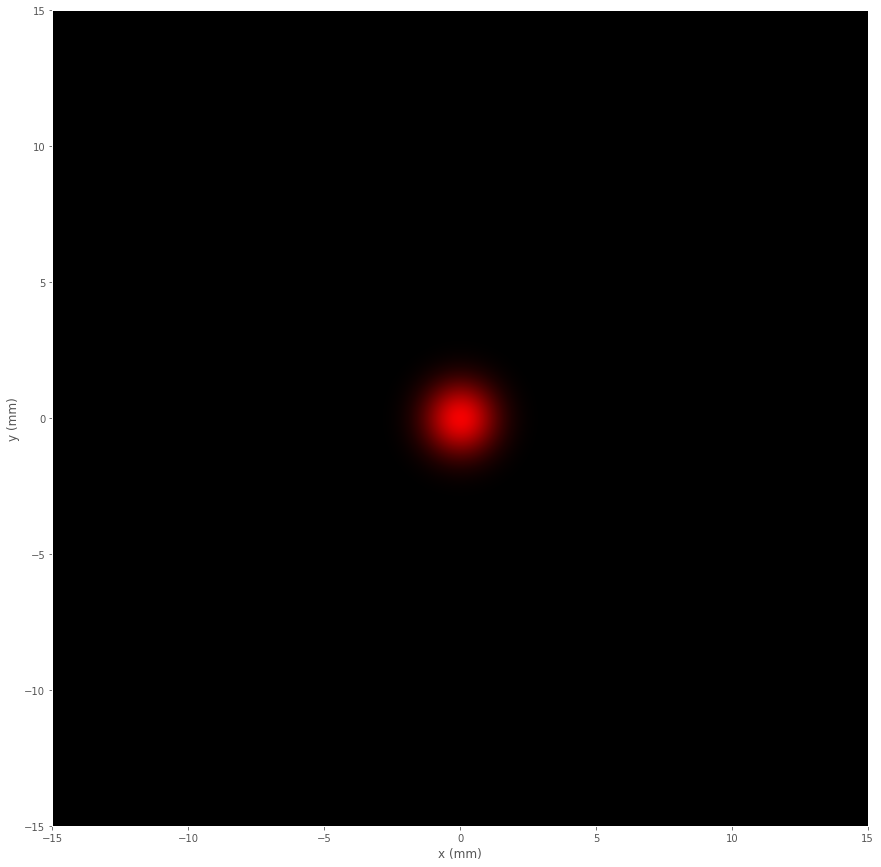

In [191]:
OutputField, FieldModuleMemory = propagate(InputField, k0, 
    grid_setup=grid_setup, keep_memory=True)
OutputPower = cp.abs(OutputField)**2
fig, ax, im = plot(OutputPower, width=Lx*0.5e3)
fig.savefig("gaussianoutputfield.pdf")
plt.show()
plt.close()

In [0]:
save_animation(FieldModuleMemory**2, "gaussian_beam.mp4", axis=2)

Propagation of a red (wider) and a blue (thiner) beam.

Lasted 0.040140628814697266 seconds
Lasted 0.029052257537841797 seconds


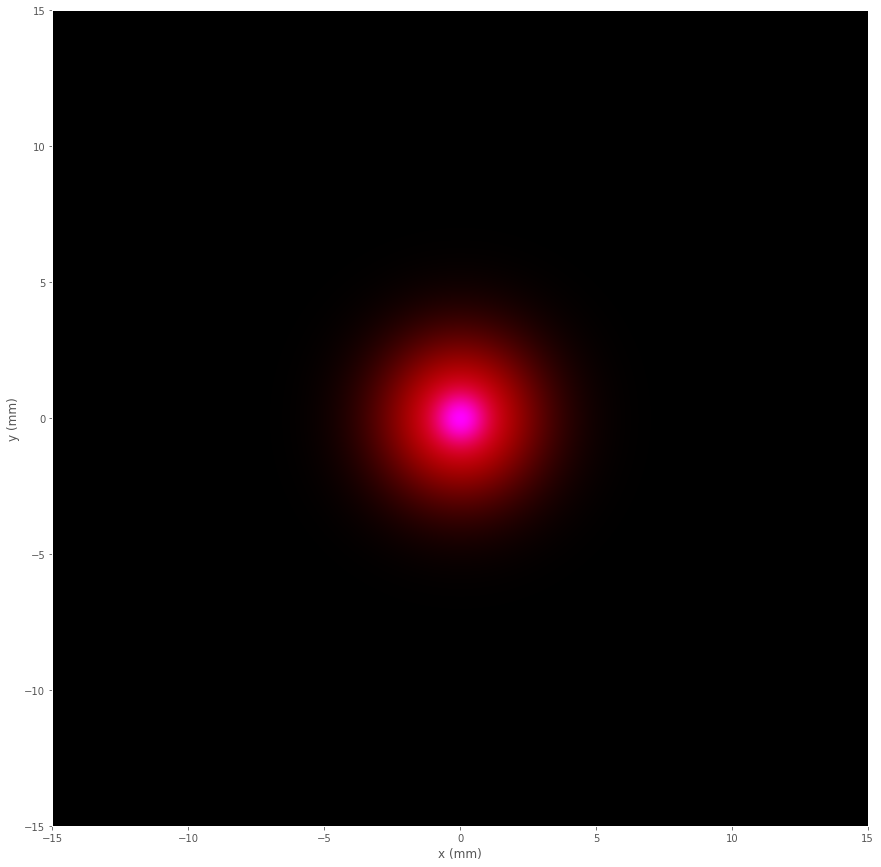

In [0]:
InputField1 = cp.sqrt(Ip)*cp.exp(-((X)**2+(Y)**2)/(49*w0**2)); #7x larger
InputField2 = cp.sqrt(Ip)*cp.exp(-((X)**2+(Y)**2)/(w0**2));

RedPower = propagate_and_get_rgb(InputField1, 0.645e-6, grid=grid_setup)
BluePower = propagate_and_get_rgb(InputField, 0.44e-6, grid=grid_setup)
fig, ax, im = plot(RedPower + BluePower) #purple point with red cirle 
# red + blue = purple
fig.savefig("redbluegaussianbeam.pdf")
plt.show()
plt.close()

In [0]:
# we evaluate beam widths (FWHM) as the 2nd moment of a gaussian function

def get_widths(FieldModuleMemory):
  # extends grids X and Y to a third axis
  # in order to make possible multiplying by FieldModuleMemory
  _X = cp.stack((X,)*(nstepz+1), axis=-1)
  _Y = cp.stack((Y,)*(nstepz+1), axis=-1)

  norms = cp.sum(FieldModuleMemory, axis=(0, 1))
  widths = cp.sqrt(np.sum((_X**2+_Y**2)*FieldModuleMemory, axis=(0, 1))/norms)
  return widths

In [111]:
z, widths = cp.asnumpy(z), cp.asnumpy(get_widths(FieldModuleMemory))
plt.scatter(z, 1000*widths)
z0 = k0*w0**2/2 # Rayleigh's width
plt.plot(z, 1000*w0*np.sqrt(1+z**2/z0**2))
plt.xlabel("z (m)")
plt.ylabel("width (mm)")
plt.title("Gaussian beam FWHM during propagation")
plt.savefig("gaussianbeamfwhm.pdf")
plt.show()

NameError: ignored

# Diffraction Grating

In [0]:
################### Physical Parameters  ########################
Ip = 4**2; # peak intensity               
Ib = 1.0; # background illumination                       
Lambda = 0.651e-6; # wavelength
k0 = 2*np.pi/Lambda; # vacuum wavevector                 
n0 = 1; # background index of refraction      
Lz = 0.12; # computational length of sample    
Lx = 40e-3; # computational width of sample          

w0 = 0.25e-3 # beam width of gaussian beam parameter
dist = 5e-6 # distance between slits
width = 1e-6 # width of slits

################## Computational Parameters #############
nstepx = 2024*32; # number of transverse grid points
nstepz = 1024; # number of longitudinal propagation steps

deltax = Lx/nstepx;
deltaz = Lz/nstepz; # resolution in the z direction, IMPORTANT
deltaf = 1/Lx; # spatial frequency step

In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = cp.arange(0, Lz+deltaz, deltaz) # z array            
x = -Lx/2 +(cp.arange(0, nstepx, 1))*deltax; # x array
##########################  Dispersive Step Setup #########################
# this is to get rid of fftshifts and the sort

ntx = 0;             
kx = cp.zeros(nstepx)                                          
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*cp.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

grid_setup = (nstepx, nstepz, deltaz, kx**2)

In [0]:
PlaneInputField = 0*x

N = 100
PlaneInputField += cp.sqrt(Ip)*(cp.exp(-(x)**20/(width**20)))
for n in range(1, N+1):
  PlaneInputField += cp.sqrt(Ip)*(cp.exp(-(x-n*dist)**20/(width**20))+cp.exp(-(x+n*dist)**20/(width**20)))

PlaneInputField = PlaneInputField * cp.exp(-(x)**2/(w0**2))

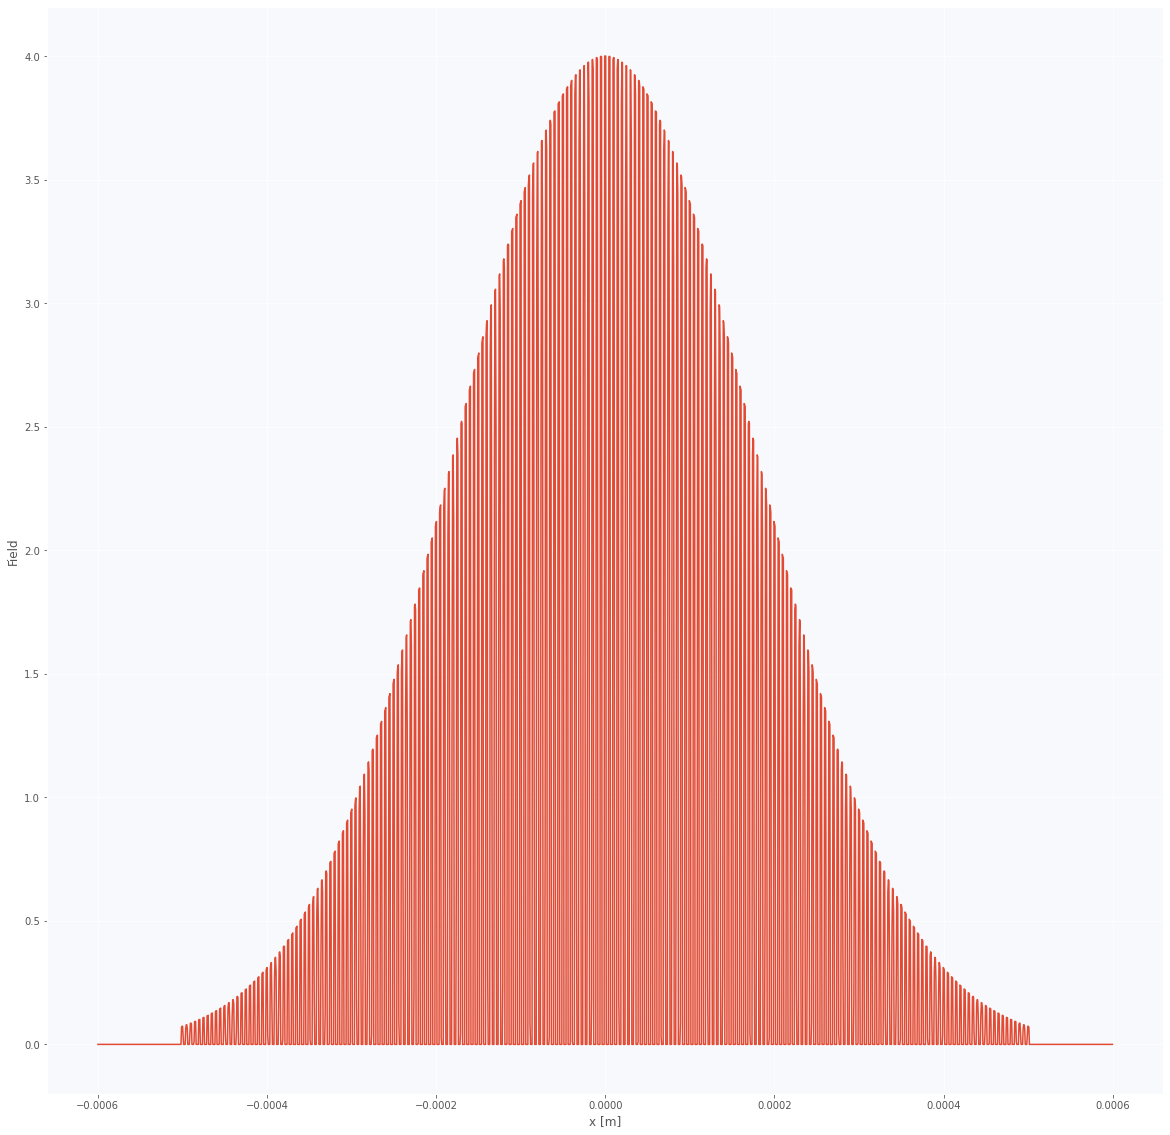

In [13]:
fig, ax = plt.subplots(figsize=(20, 20))
x_range = cp.abs(x)<6e-4
ax.plot(cp.asnumpy(x[x_range]), cp.asnumpy(PlaneInputField[x_range]))
ax.set(xlabel="x [m]", ylabel="Field")
fig.savefig("gratinginputfield.pdf")
plt.show()
plt.close()

Lasted 1.0012993812561035 seconds
Lasted 0.9880573749542236 seconds


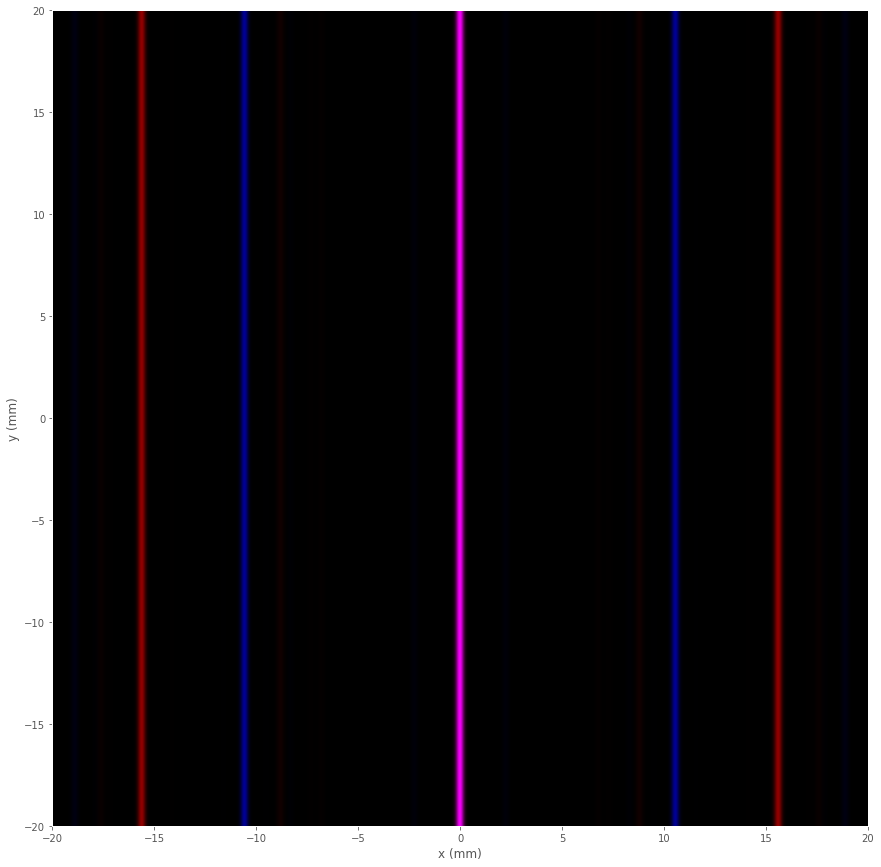

In [0]:
Red = propagate_and_get_rgb(PlaneInputField, 0.65e-6, grid=grid_setup)
Blue = propagate_and_get_rgb(PlaneInputField, 0.44e-6, grid=grid_setup)

fig, ax, im = plot((Red+Blue), width=20, OneD=True)
fig.savefig("redbluegrating.pdf")
plt.show()
plt.close()

Come previsto i massimi più visibili sono 3 in totale, uno al centro e gli altri due più lontani ma simmetrici.

Lasted 1.0186610221862793 seconds
Lasted 1.0168428421020508 seconds


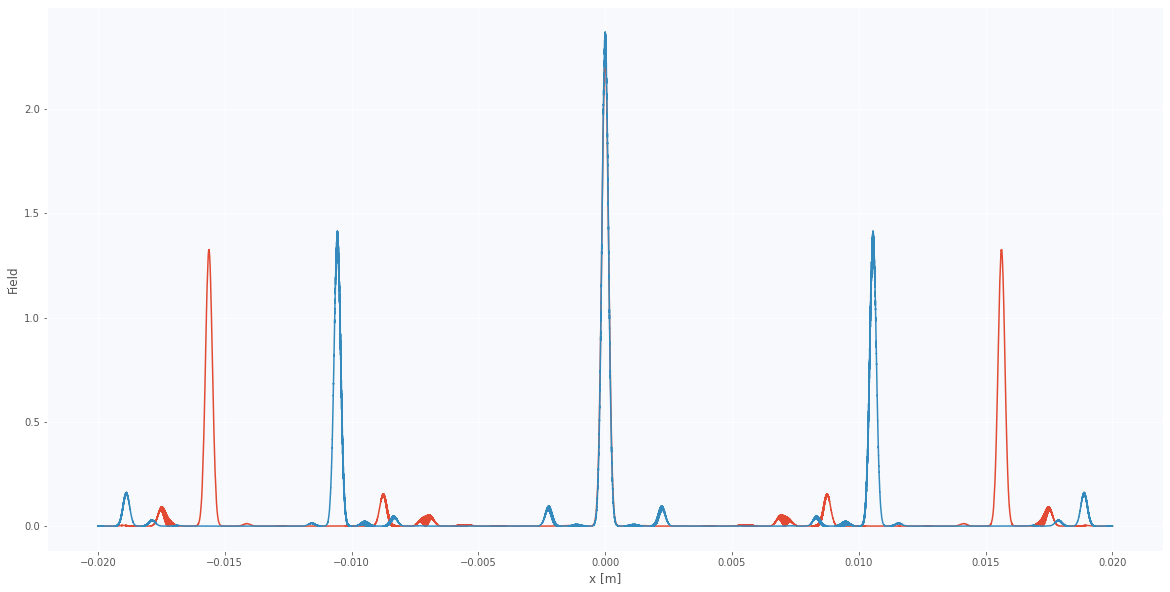

In [0]:
OutputField = propagate(PlaneInputField, k0, grid_setup=grid_setup)
intensity = cp.abs(OutputField)**2
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(cp.asnumpy(x), cp.asnumpy(intensity))
OutputField = propagate(PlaneInputField, 2*np.pi/0.44e-6, grid_setup=grid_setup)

intensity = cp.abs(OutputField)**2
ax.plot(cp.asnumpy(x), cp.asnumpy(intensity))
ax.set(xlabel="x [m]", ylabel="Field")
fig.savefig("peaksgrating.pdf")
plt.show()
plt.close()

Per il rosso, i massimi sono distanti circa 16 mm dal centro, e lo schermo è lontano 120mm dal reticolo: $\sin(\theta) = 16/120 = 0.13$.<br>
La distanza tra le slits vale 5 micron, a fronte di una lunghezza d'onda di 0.65 micron. Dunque $d/\lambda = 0.65/5 = 0.13 = \sin(\theta)$ come previsto.

Valutiamo il potere risolutivo.

Lasted 1.0212981700897217 seconds
Lasted 1.0663912296295166 seconds


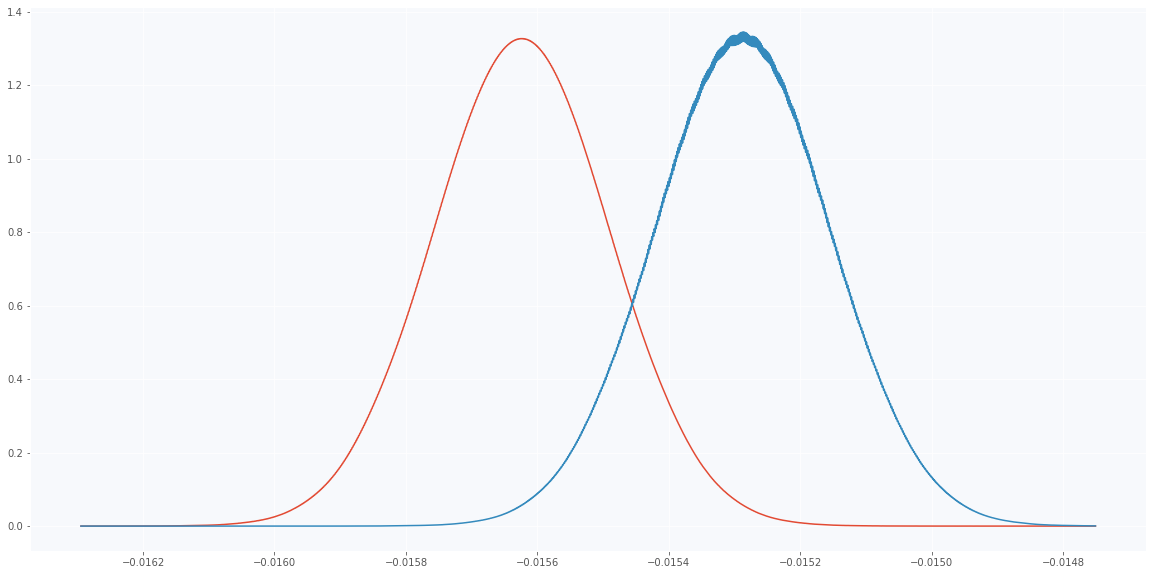

In [0]:
OutputField = propagate(PlaneInputField, 2*cp.pi/0.651e-6, grid_setup=grid_setup)
intensity1 = cp.abs(OutputField)**2

OutputField = propagate(PlaneInputField, 2*cp.pi/0.637e-6, grid_setup=grid_setup)
intensity2 = cp.abs(OutputField)**2

xrange = cp.arange(6000, 8500)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(cp.asnumpy(x[xrange]), cp.asnumpy(intensity1[xrange]))
ax.plot(cp.asnumpy(x[xrange]), cp.asnumpy(intensity2[xrange]))
fig.savefig("taylor.pdf")
plt.show()
plt.close()

Le lunghezze d'onda hanno 14nm di differenza. Il potere risolutivo dunque vale 651/14 = 47.

In [14]:
output = cp.zeros((nstepx, 3))
memory = cp.zeros((nstepx, nstepz+1, 3))
wavelengths = np.linspace(380, 750, 30) # light with 30 colors
for wl in wavelengths:
  single_out, single_mem = propagate_and_get_rgb(PlaneInputField, wl*1e-9, grid=grid_setup, keep_memory=True)
  output += single_out
  memory += single_mem

Lasted 1.8574719429016113 seconds
Lasted 1.1453595161437988 seconds
Lasted 1.1909418106079102 seconds
Lasted 1.187788963317871 seconds
Lasted 1.2594983577728271 seconds
Lasted 1.2143135070800781 seconds
Lasted 1.2484338283538818 seconds
Lasted 1.2202718257904053 seconds
Lasted 1.1908314228057861 seconds
Lasted 1.1766366958618164 seconds
Lasted 1.181384801864624 seconds
Lasted 1.2133152484893799 seconds
Lasted 1.1866357326507568 seconds
Lasted 1.1388182640075684 seconds
Lasted 1.1698720455169678 seconds
Lasted 1.1325218677520752 seconds
Lasted 1.2324957847595215 seconds
Lasted 1.1656501293182373 seconds
Lasted 1.1512668132781982 seconds
Lasted 1.146953821182251 seconds
Lasted 1.1479363441467285 seconds
Lasted 1.159898042678833 seconds
Lasted 1.1740455627441406 seconds
Lasted 1.200465202331543 seconds
Lasted 1.1431512832641602 seconds
Lasted 1.1409213542938232 seconds
Lasted 1.191406488418579 seconds
Lasted 1.1446220874786377 seconds
Lasted 1.1380541324615479 seconds
Lasted 1.14710855484

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


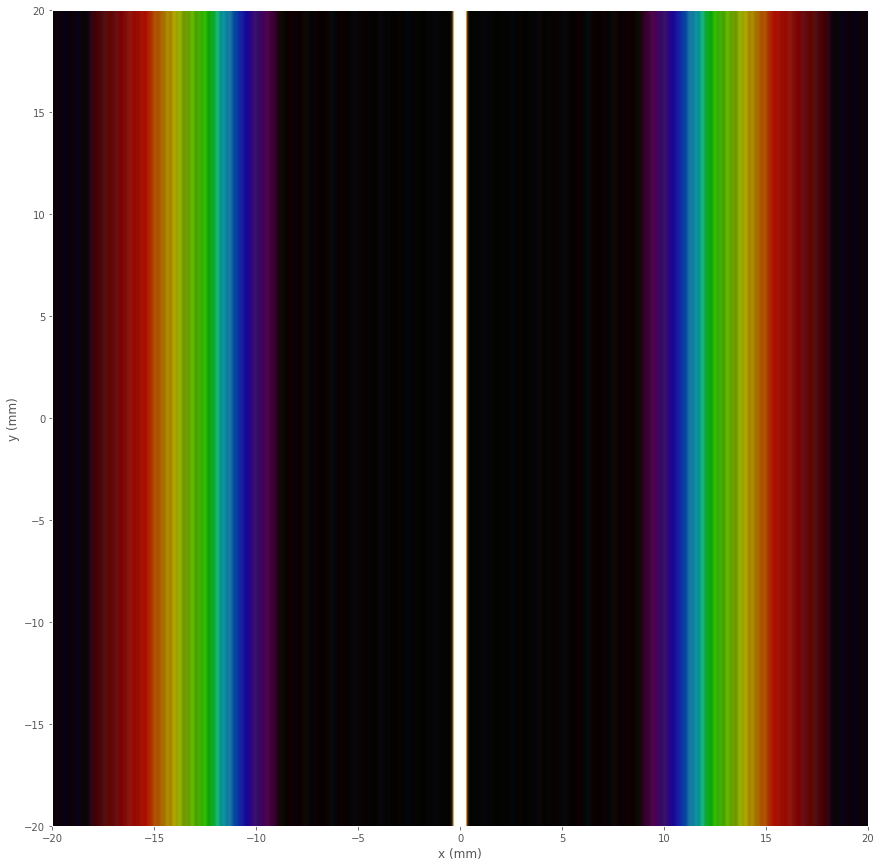

In [198]:
fig, ax, im = plot(output, width=20, OneD=True)
fig.savefig("rainbow.pdf")
plt.show()
plt.close()

In [0]:
save_animation(memory, "rainbow1.mp4", axis=1, every=20, OneD=True, width=20, blit=True)

# Lens

In [31]:
!wget https://github.com/raeubaen/ml/blob/master/refractiveindex.xlsx?raw=true -O glass_n.xlsx
import pandas
df = pandas.read_excel("glass_n.xlsx", names=["wl", "n"])

--2020-05-30 11:46:35--  https://github.com/raeubaen/ml/blob/master/refractiveindex.xlsx?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/raeubaen/ml/raw/master/refractiveindex.xlsx [following]
--2020-05-30 11:46:36--  https://github.com/raeubaen/ml/raw/master/refractiveindex.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/raeubaen/ml/master/refractiveindex.xlsx [following]
--2020-05-30 11:46:36--  https://raw.githubusercontent.com/raeubaen/ml/master/refractiveindex.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [48]:
df = (df[df.wl<0.75])[df.wl>0.35]
df

,wl,n,wl_m
15,0.3530,1.476395,3.530000e-07
16,0.3655,1.474468,3.655000e-07
17,0.3783,1.472705,3.783000e-07
18,0.3917,1.471053,3.917000e-07
19,0.4055,1.469529,4.055000e-07
20,0.4197,1.468122,4.197000e-07
21,0.4345,1.466805,4.345000e-07
22,0.4498,1.465581,4.498000e-07
23,0.4657,1.464436,4.657000e-07
24,0.4821,1.463372,4.821000e-07


Il fit può essere utile per avere l'indice di rifrazione per ogni colore, ma in realtà i circa 30 punti da wl>0.3 in poi bastano per comporre luce bianca.

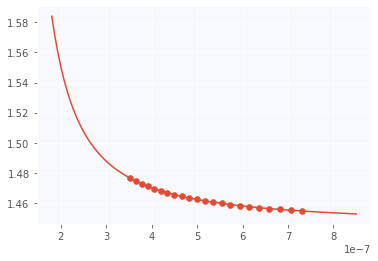

In [49]:
def get_n(wl, a, b, c):
  return a*(np.exp(b/wl)-1)+c
(a, b, c), pcov = curve_fit(get_n, df.wl, df.n)

wl_m = np.linspace(0.18, 0.85, 100)*1e-6
b = b*1e-6
df["wl_m"] = df.wl*1e-6
n = get_n(wl_m, a, b, c)

plt.scatter(df.wl_m, df.n)
plt.plot(wl_m, n)

In [0]:
################### Physical Parameters  ########################
Ip = 4**2; # peak intensity               
Ib = 1.0; # background illumination                             
Lambda = 0.651e-6; # wavelength
k0 = 2*np.pi/Lambda; # vacuum wavevector                 
n0 = 1; # background index of refraction      
Lz = 1; # computational length of sample    
Lx = 30e-3; # computational width of sample          
Chirp = -0.0*6*230000.0; # input linear chirp parameter         
h = 0*0.67e-3;
xshift = +h/2; # input position on x axis               
w0 = 0.5e-3 # beam width of gaussian beam parameter

fl = 0.4; # focal length

################## Computational Parameters #############
nstepx = 1024; # number of transverse grid points
nstepz = 40; # number of longitudinal propagation steps

deltax = Lx/nstepx;
deltaz = Lz/nstepz; # resolution in the z direction, IMPORTANT
deltaf = 1/Lx; # spatial frequency step

In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = cp.arange(0, Lz+deltaz, deltaz) # z array            
x = -Lx/2 +(cp.arange(0, nstepx, 1))*deltax; # x array               

X, Y = cp.meshgrid(x,x); # x and y grid

##########################  Dispersive Step Setup #########################
# this is to get rid of fftshifts and the sort

ntx = 0;             
kx = cp.zeros(nstepx)                                          
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*np.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

KX, KY = cp.meshgrid(kx, kx);

grid_setup = (nstepx, nstepz, deltaz, KX**2+KY**2)

In [0]:
####################### INPUT FIELDS DEFINITION  #########################
# field outside of a lens 
Phase = cp.exp(1j*k0/(2*fl)*(X**2+Y**2))
InputField = cp.sqrt(Ip)*cp.exp(-(X**2+Y**2)/(w0**2)) * Phase

In [90]:
out, mem = propagate(InputField, k0, grid_setup=grid_setup, keep_memory=True)

Lasted 0.07374238967895508 seconds


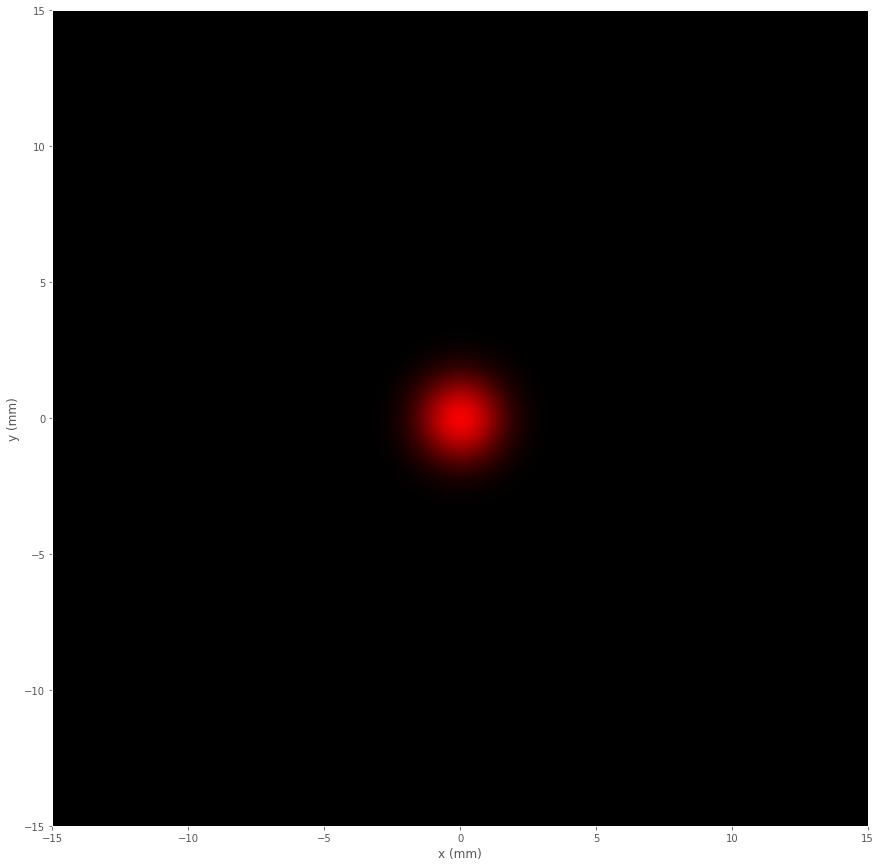

In [44]:
fig, ax, im = plot(cp.abs(out)**2)
fig.savefig("lensout.pdf")
plt.show()
plt.close()

In [0]:
# we evaluate beam widths (FWHM) as the 2nd moment of a gaussian function

def get_widths(FieldModuleMemory):
  # extends grids X and Y to a third axis
  # in order to make possible multiplying by FieldModuleMemory
  _X = cp.stack((X,)*(nstepz+1), axis=-1)
  _Y = cp.stack((Y,)*(nstepz+1), axis=-1)

  norms = cp.sum(FieldModuleMemory, axis=(0, 1))
  widths = cp.sqrt(np.sum((_X**2+_Y**2)*FieldModuleMemory, axis=(0, 1))/norms)
  return widths

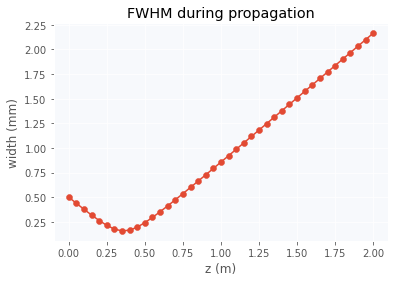

In [133]:
z, widths = cp.asnumpy(z), cp.asnumpy(get_widths(mem))
plt.scatter(z, 1000*widths)
plt.xlabel("z (m)")
plt.ylabel("width (mm)")
plt.title("FWHM during propagation")

def fwhm(z, a, b, c):
  y = a*np.sqrt(1+(z-b)**2/c**2)
  return y

(a, b, c), pcov = curve_fit(fwhm, xdata=z, ydata=widths)
plt.plot(z, 1000*fwhm(z, a, b, c))
plt.savefig("lensgaussianbeamfwhm.pdf")
plt.show()

In [0]:
save_animation(mem**2, "lens.mp4", axis=2, blit=True)

In [64]:
output = cp.zeros((nstepx, nstepx, 3))
memory = cp.zeros((nstepx, nstepx, nstepz+1, 3))
GaussianField = cp.sqrt(Ip)*cp.exp(-(X**2+Y**2)/(w0**2))
for wl, n  in zip(df.wl_m, df.n):
  fl_at_wl = fl/(n-1)
  Phase = cp.exp(1j*k0/(2*fl_at_wl)*(X**2+Y**2))
  InputField = GaussianField * Phase
  single_out, single_mem = propagate_and_get_rgb(InputField, wl, grid=grid_setup, keep_memory=True)
  output += single_out
  memory += single_mem

Lasted 0.06575679779052734 seconds
Lasted 0.06225299835205078 seconds
Lasted 0.0657186508178711 seconds
Lasted 0.22968149185180664 seconds
Lasted 0.2783787250518799 seconds
Lasted 0.2677445411682129 seconds
Lasted 0.26941633224487305 seconds
Lasted 0.27042579650878906 seconds
Lasted 0.2680933475494385 seconds
Lasted 0.26918840408325195 seconds
Lasted 0.26952457427978516 seconds
Lasted 0.26961445808410645 seconds
Lasted 0.26951169967651367 seconds
Lasted 0.2682375907897949 seconds
Lasted 0.2682194709777832 seconds
Lasted 0.26952528953552246 seconds
Lasted 0.2704284191131592 seconds
Lasted 0.26737284660339355 seconds
Lasted 0.26968884468078613 seconds
Lasted 0.2698249816894531 seconds
Lasted 0.26993250846862793 seconds
Lasted 0.2705960273742676 seconds


In [0]:
save_animation(memory, "lens_chrom.mp4", axis=2, blit=True)

In [141]:
output = cp.zeros((nstepx, nstepx, 3))
memory = cp.zeros((nstepx, nstepx, nstepz+1, 3))
GaussianField = cp.sqrt(Ip)*cp.exp(-(X**2+Y**2)/(w0**2))
red_blue = pandas.concat([df[df.wl==0.4498], df.tail(1)])
for wl, n  in zip(red_blue.wl_m, red_blue.n):
  fl_at_wl = fl/(n-1)
  Phase = cp.exp(1j*k0/(2*fl_at_wl)*(X**2+Y**2))
  InputField = GaussianField * Phase
  single_out, single_mem = propagate_and_get_rgb(InputField, wl, grid=grid_setup, keep_memory=True)
  output += single_out
  memory += single_mem

Lasted 0.06755852699279785 seconds
Lasted 0.06267619132995605 seconds


In [142]:
save_animation(memory, "lens_chrom_red_purple.mp4", axis=2, blit=True)

0.975609756097561:.1f

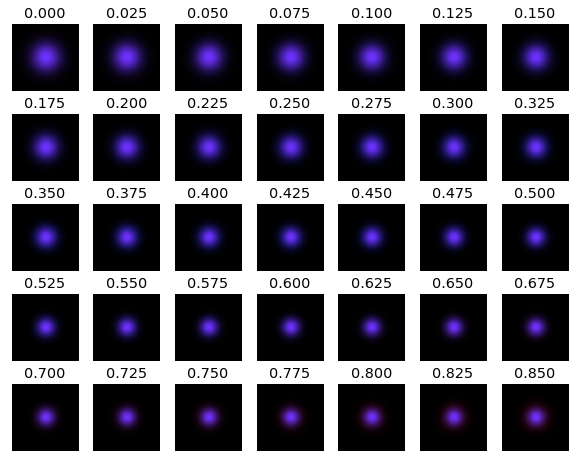

In [168]:
cols = 7
N = memory.shape[2]
rows = int(N/cols)
fig, axs = plt.subplots(rows, cols, figsize=(10, 8))
for i in range(rows):
  for j in range(cols):
    plot(memory[512-30:512+30, 512-30:512+30, cols*i+j, :], fig=fig, ax=axs[i][j])
    axs[i][j].set(xticks=[], yticks=[], xlabel="", ylabel="")
    axs[i][j].set_title(f"{(cols*i+j)*deltaz:.3f}")
fig.savefig("lens_plane_wave.pdf")
plt.show()
plt.close()

In [129]:
GaussianField = cp.sqrt(Ip)*cp.exp(-(X**2+Y**2)/(w0**2))
red_df, blue_df = df.tail(1), df[df.wl==0.4498]
red_n, blue_n = cp.asarray(red_df.n), cp.asarray(blue_df.n)
red_wl, blue_wl = cp.asarray(red_df.wl_m), cp.asarray(blue_df.wl_m) # meters
red_fl, blue_fl = fl/(red_n-1), fl/(blue_n-1)
print(red_fl, blue_fl)
RedField = GaussianField * cp.exp(1j*(2*cp.pi/red_wl)/(2*red_fl)*(X**2+Y**2))
BlueField = GaussianField * cp.exp(1j*(2*cp.pi/blue_wl)/(2*blue_fl)*(X**2+Y**2))

RedOut, RedMem = propagate(RedField, 2*cp.pi/red_wl, grid_setup=grid_setup, keep_memory=True)
BlueOut, BlueMem = propagate(RedField, 2*cp.pi/blue_wl, grid_setup=grid_setup, keep_memory=True)

[0.87983659] [0.8591419]
Lasted 0.0810708999633789 seconds
Lasted 0.06984806060791016 seconds


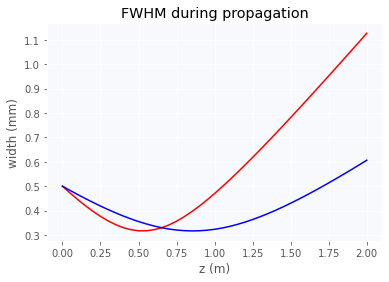

In [131]:
z = cp.asnumpy(z)
red_widths, blue_widths = cp.asnumpy(get_widths(RedMem)), cp.asnumpy(get_widths(BlueMem))
plt.plot(z, 1000*red_widths, 'r')
plt.plot(z, 1000*blue_widths, 'b')
plt.xlabel("z (m)")
plt.ylabel("width (mm)")
plt.title("FWHM during propagation")
plt.savefig("fwhmlensgaussianbeamredblue.pdf")
plt.show()
plt.close()